In [255]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce
import datetime


In [256]:
L = 5 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=2
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [257]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
       0.         |2 2 2 2 2>           242  
       1.         |2 2 2 2 1>           241  
       2.         |2 2 2 2 0>           240  
       3.         |2 2 2 1 2>           239  
       4.         |2 2 2 1 1>           238  
       5.         |2 2 2 1 0>           237  
       6.         |2 2 2 0 2>           236  
       7.         |2 2 2 0 1>           235  
       8.         |2 2 2 0 0>           234  
       9.         |2 2 1 2 2>           233  
      10.         |2 2 1 2 1>           232  
      11.         |2 2 1 2 0>           231  
      12.         |2 2 1 1 2>           230  
      13.         |2 2 1 1 1>           229  
      14.         |2 2 1 1 0>           228  
      15.         |2 2 1 0 2>           227  
      16.         |2 2 1 0 1>           226  
      17.         |2 2 1 0 0>           225  
      18.         |2 2 0 2 2>           224  
      19.         |2 2 0 2 1>           223  
      20.  

In [258]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [259]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [260]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [261]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [262]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [263]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [264]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [265]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [266]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [267]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-1.0416023  -0.0142565   0.15174042]


In [268]:
#s_xy = [[1.,i,i+1] for i in range(L-1)]
#s_z = [[0.47,i] for i in range(L)]

#ham_map = [
    
#    ["xx",s_xy],
#    ["yy",s_xy],
#    ["z",s_z],


#]

#XYZ = hamiltonian(ham_map,dynamic_list=[],basis=basis,**no_checks)


In [269]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [270]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [271]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [272]:
def R(i,theta):
    
    if i%10 == 0:
        return(ms_gate_global(theta))

    if i%10 == 1:
        return(rot_sigma_e(0,1,0,theta).toarray())


    if i%10 == 2:
        return(rot_sigma_e(0,2,0,theta).toarray())

    
    if i%10 == 3:
        return(rot_sigma_e(1,2,np.pi/2,theta).toarray())
    
    
    if i%10 == 4:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%10 == 5:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%10 == 6:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%10 == 7:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%10 == 8:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%10 == 9:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
    
def S(i):
    
    if i%10 == 0:
        return(-1j*matrix_part)


    if i%10 == 1:
        return(-1j*sigma_e(0,1,0).toarray())

    
    if i%10 == 2:
        return(-1j*sigma_e(0,2,0).toarray())

    
    if i%10 == 3:
        return(-1j*sigma_e(1,2,np.pi/2).toarray())


     
    if i%10 == 4:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%10 == 5:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%10 == 6:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%10 == 7:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%10 == 8:
        return(-1j*sigma_r(0,2,0).toarray())

    
    if i%10 == 9:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())


In [273]:
coeff = 10

In [274]:
matr = full_ham_matrix.toarray()
ones = np.ones(coeff*N)
ID = np.identity(coeff*N)
psi_0_conj = np.conj(psi_0)
A = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
dd = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]

In [275]:
def rhs(t,theta):
    #A = [-1j*entanglement_ham.toarray()@exp_ent(theta[0]),-1j*sigma_z.toarray()@exp_sigma_z(theta[1]),-1j*sigma_x.toarray()@exp_sigma_x(theta[2]),-1j*sigma_z.toarray()@exp_sigma_z(theta[3])]
    #B = [exp_ent(theta[0]),exp_sigma_z(theta[1]),exp_sigma_x(theta[2]),exp_sigma_z(theta[3])]
    ID = np.identity(coeff*N)

    print(datetime.datetime.now())
    for k in range(coeff*N):
        A[k] = S(k)@R(k,theta[k])
        B[k] = R(k,theta[k])

    CC = np.einsum("i,ljk->iljk",np.ones(coeff*N),B)

    AA = np.einsum("ijk,il->iljk",A,ID)

    BB = np.einsum("ijk,il->iljk",B,ID)

    DD = CC-BB+AA

    for i in range(coeff*N):
        dd[i] = reduce(np.dot,DD[i])
    DD = np.array(dd)

    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)

    BBB = reduce(np.dot,B)
    DD_d = np.einsum("kij->kji",DD.conj())
    BBB_dagger = BBB.conj().T

    
    
    psi_conj_d = np.einsum("m,imn->in",psi_0_conj,DD_d)
    psi_d = np.einsum("jnl,l->jn",DD,psi_0)
    
    psi_conj_b = np.einsum("m,mn->n",psi_0_conj,BBB_dagger)
    psi_b = np.einsum("lk,k->l",BBB,psi_0)

    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [276]:
stepp = 1000

In [277]:
time_domain = np.linspace(0, 10, stepp)
Y = []

In [278]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [279]:
start_point = 0.001*np.ones(coeff*N)
#for i in range(4*N):
#    start_point[i] += i/4*N
rk4(0,0.001*np.ones(coeff*N),10,stepp)


2022-07-21 20:50:40.442143
2022-07-21 20:50:42.582806
0
2022-07-21 20:50:42.584889
2022-07-21 20:50:44.715557
0.005
2022-07-21 20:50:44.717586
2022-07-21 20:50:46.486277
0.005
2022-07-21 20:50:46.488379
2022-07-21 20:50:48.072428
0.01
2022-07-21 20:50:48.074494
2022-07-21 20:50:50.085184
0.01
2022-07-21 20:50:50.087168
2022-07-21 20:50:51.674777
0.015
2022-07-21 20:50:51.677152
2022-07-21 20:50:53.346524
0.015
2022-07-21 20:50:53.348585
2022-07-21 20:50:55.058770
0.02
2022-07-21 20:50:55.060936
2022-07-21 20:50:56.990446
0.02
2022-07-21 20:50:56.992457
2022-07-21 20:50:58.484074
0.025
2022-07-21 20:50:58.486283
2022-07-21 20:51:00.500430
0.025
2022-07-21 20:51:00.502608
2022-07-21 20:51:02.422296
0.03
2022-07-21 20:51:02.424489
2022-07-21 20:51:04.099951
0.03
2022-07-21 20:51:04.102143
2022-07-21 20:51:05.705611
0.034999999999999996
2022-07-21 20:51:05.707697
2022-07-21 20:51:07.788977
0.034999999999999996
2022-07-21 20:51:07.791192
2022-07-21 20:51:09.534201
0.04
2022-07-21 20:51:09.5

2022-07-21 20:54:34.842325
0.3000000000000001
2022-07-21 20:54:34.845098
2022-07-21 20:54:37.048567
0.3050000000000001
2022-07-21 20:54:37.051049
2022-07-21 20:54:38.861629
0.3050000000000001
2022-07-21 20:54:38.864051
2022-07-21 20:54:40.953277
0.3100000000000001
2022-07-21 20:54:40.955936
2022-07-21 20:54:42.838867
0.3100000000000001
2022-07-21 20:54:42.841466
2022-07-21 20:54:45.025427
0.3150000000000001
2022-07-21 20:54:45.028012
2022-07-21 20:54:46.606689
0.3150000000000001
2022-07-21 20:54:46.609303
2022-07-21 20:54:48.736187
0.3200000000000001
2022-07-21 20:54:48.738516
2022-07-21 20:54:50.832679
0.3200000000000001
2022-07-21 20:54:50.835262
2022-07-21 20:54:52.732369
0.3250000000000001
2022-07-21 20:54:52.735060
2022-07-21 20:54:54.917096
0.3250000000000001
2022-07-21 20:54:54.919541
2022-07-21 20:54:57.172800
0.3300000000000001
2022-07-21 20:54:57.175290
2022-07-21 20:54:59.483793
0.3300000000000001
2022-07-21 20:54:59.486306
2022-07-21 20:55:01.481243
0.33500000000000013
2022

2022-07-21 20:58:42.865633
0.5800000000000003
2022-07-21 20:58:42.868123
2022-07-21 20:58:45.080547
0.5850000000000003
2022-07-21 20:58:45.083427
2022-07-21 20:58:46.963446
0.5850000000000003
2022-07-21 20:58:46.965995
2022-07-21 20:58:49.199958
0.5900000000000003
2022-07-21 20:58:49.202586
2022-07-21 20:58:51.419559
0.5900000000000003
2022-07-21 20:58:51.422193
2022-07-21 20:58:53.520982
0.5950000000000003
2022-07-21 20:58:53.523754
2022-07-21 20:58:55.932522
0.5950000000000003
2022-07-21 20:58:55.935327
2022-07-21 20:58:58.183128
0.6000000000000003
2022-07-21 20:58:58.186312
2022-07-21 20:59:00.521816
0.6000000000000003
2022-07-21 20:59:00.524619
2022-07-21 20:59:02.469361
0.6050000000000003
2022-07-21 20:59:02.471878
2022-07-21 20:59:04.826646
0.6050000000000003
2022-07-21 20:59:04.829151
2022-07-21 20:59:07.276297
0.6100000000000003
2022-07-21 20:59:07.279096
2022-07-21 20:59:09.616282
0.6100000000000003
2022-07-21 20:59:09.618842
2022-07-21 20:59:11.280743
0.6150000000000003
2022-

2022-07-21 21:02:43.743535
0.8650000000000005
2022-07-21 21:02:43.746070
2022-07-21 21:02:46.234562
0.8650000000000005
2022-07-21 21:02:46.237100
2022-07-21 21:02:48.362262
0.8700000000000006
2022-07-21 21:02:48.364761
2022-07-21 21:02:50.692956
0.8700000000000006
2022-07-21 21:02:50.695427
2022-07-21 21:02:52.846882
0.8750000000000006
2022-07-21 21:02:52.849543
2022-07-21 21:02:55.377846
0.8750000000000006
2022-07-21 21:02:55.380426
2022-07-21 21:02:56.883768
0.8800000000000006
2022-07-21 21:02:56.886420
2022-07-21 21:02:59.525714
0.8800000000000006
2022-07-21 21:02:59.528203
2022-07-21 21:03:01.702307
0.8850000000000006
2022-07-21 21:03:01.704791
2022-07-21 21:03:03.645544
0.8850000000000006
2022-07-21 21:03:03.648123
2022-07-21 21:03:06.181103
0.8900000000000006
2022-07-21 21:03:06.183991
2022-07-21 21:03:08.181555
0.8900000000000006
2022-07-21 21:03:08.184142
2022-07-21 21:03:10.473709
0.8950000000000006
2022-07-21 21:03:10.476584
2022-07-21 21:03:12.418520
0.8950000000000006
2022-

2022-07-21 21:06:39.407344
1.1450000000000007
2022-07-21 21:06:39.409897
2022-07-21 21:06:41.452712
1.1500000000000008
2022-07-21 21:06:41.455251
2022-07-21 21:06:43.914722
1.1500000000000008
2022-07-21 21:06:43.918039
2022-07-21 21:06:45.559224
1.1550000000000007
2022-07-21 21:06:45.561968
2022-07-21 21:06:47.947081
1.1550000000000007
2022-07-21 21:06:47.949757
2022-07-21 21:06:49.973474
1.1600000000000008
2022-07-21 21:06:49.976019
2022-07-21 21:06:52.103925
1.1600000000000008
2022-07-21 21:06:52.106504
2022-07-21 21:06:54.344468
1.1650000000000007
2022-07-21 21:06:54.347147
2022-07-21 21:06:56.241728
1.1650000000000007
2022-07-21 21:06:56.244357
2022-07-21 21:06:58.658190
1.1700000000000008
2022-07-21 21:06:58.660729
2022-07-21 21:07:00.593514
1.1700000000000008
2022-07-21 21:07:00.596037
2022-07-21 21:07:02.807808
1.1750000000000007
2022-07-21 21:07:02.810372
2022-07-21 21:07:04.897613
1.1750000000000007
2022-07-21 21:07:04.900374
2022-07-21 21:07:07.244265
1.1800000000000008
2022-

2022-07-21 21:10:37.323517
1.430000000000001
2022-07-21 21:10:37.326180
2022-07-21 21:10:39.686649
1.430000000000001
2022-07-21 21:10:39.689354
2022-07-21 21:10:41.700242
1.435000000000001
2022-07-21 21:10:41.702855
2022-07-21 21:10:43.723835
1.435000000000001
2022-07-21 21:10:43.726472
2022-07-21 21:10:46.053229
1.440000000000001
2022-07-21 21:10:46.055979
2022-07-21 21:10:48.063130
1.440000000000001
2022-07-21 21:10:48.065736
2022-07-21 21:10:50.378907
1.445000000000001
2022-07-21 21:10:50.381538
2022-07-21 21:10:52.401874
1.445000000000001
2022-07-21 21:10:52.404471
2022-07-21 21:10:54.660704
1.450000000000001
2022-07-21 21:10:54.663863
2022-07-21 21:10:56.656969
1.450000000000001
2022-07-21 21:10:56.659652
2022-07-21 21:10:58.907078
1.455000000000001
2022-07-21 21:10:58.909863
2022-07-21 21:11:00.961450
1.455000000000001
2022-07-21 21:11:00.964047
2022-07-21 21:11:03.231071
1.460000000000001
2022-07-21 21:11:03.233790
2022-07-21 21:11:05.188171
1.460000000000001
2022-07-21 21:11:05

2022-07-21 21:14:37.164119
1.7100000000000013
2022-07-21 21:14:37.166535
2022-07-21 21:14:39.439197
1.7150000000000012
2022-07-21 21:14:39.441728
2022-07-21 21:14:41.606113
1.7150000000000012
2022-07-21 21:14:41.608640
2022-07-21 21:14:43.636482
1.7200000000000013
2022-07-21 21:14:43.639085
2022-07-21 21:14:45.943369
1.7200000000000013
2022-07-21 21:14:45.945941
2022-07-21 21:14:47.932131
1.7250000000000012
2022-07-21 21:14:47.934711
2022-07-21 21:14:50.146414
1.7250000000000012
2022-07-21 21:14:50.149035
2022-07-21 21:14:52.238319
1.7300000000000013
2022-07-21 21:14:52.241021
2022-07-21 21:14:54.525824
1.7300000000000013
2022-07-21 21:14:54.528611
2022-07-21 21:14:56.786710
1.7350000000000012
2022-07-21 21:14:56.789450
2022-07-21 21:14:58.768278
1.7350000000000012
2022-07-21 21:14:58.771162
2022-07-21 21:15:01.086215
1.7400000000000013
2022-07-21 21:15:01.088901
2022-07-21 21:15:03.207745
1.7400000000000013
2022-07-21 21:15:03.210474
2022-07-21 21:15:05.577922
1.7450000000000012
2022-

2022-07-21 21:18:39.759766
1.9950000000000014
2022-07-21 21:18:39.762280
2022-07-21 21:18:42.061167
1.9950000000000014
2022-07-21 21:18:42.063651
2022-07-21 21:18:44.091029
2.0000000000000013
2022-07-21 21:18:44.093492
2022-07-21 21:18:46.395581
2.0000000000000013
2022-07-21 21:18:46.398320
2022-07-21 21:18:48.720835
2.0050000000000012
2022-07-21 21:18:48.723439
2022-07-21 21:18:50.936461
2.0050000000000012
2022-07-21 21:18:50.938974
2022-07-21 21:18:53.020923
2.010000000000001
2022-07-21 21:18:53.023543
2022-07-21 21:18:55.358694
2.010000000000001
2022-07-21 21:18:55.361318
2022-07-21 21:18:57.132487
2.015000000000001
2022-07-21 21:18:57.135126
2022-07-21 21:18:59.065749
2.015000000000001
2022-07-21 21:18:59.068423
2022-07-21 21:19:01.323869
2.020000000000001
2022-07-21 21:19:01.326975
2022-07-21 21:19:03.551310
2.020000000000001
2022-07-21 21:19:03.554116
2022-07-21 21:19:05.843801
2.025000000000001
2022-07-21 21:19:05.846524
2022-07-21 21:19:07.892991
2.025000000000001
2022-07-21 21

2022-07-21 21:22:54.729283
2.2799999999999954
2022-07-21 21:22:54.732056
2022-07-21 21:22:56.721279
2.2849999999999953
2022-07-21 21:22:56.724032
2022-07-21 21:22:59.010290
2.2849999999999953
2022-07-21 21:22:59.012882
2022-07-21 21:23:01.356634
2.289999999999995
2022-07-21 21:23:01.359175
2022-07-21 21:23:03.558169
2.289999999999995
2022-07-21 21:23:03.560652
2022-07-21 21:23:05.772535
2.294999999999995
2022-07-21 21:23:05.775029
2022-07-21 21:23:07.942102
2.294999999999995
2022-07-21 21:23:07.944657
2022-07-21 21:23:10.208010
2.299999999999995
2022-07-21 21:23:10.210655
2022-07-21 21:23:12.433535
2.299999999999995
2022-07-21 21:23:12.436032
2022-07-21 21:23:14.399503
2.304999999999995
2022-07-21 21:23:14.402168
2022-07-21 21:23:16.771428
2.304999999999995
2022-07-21 21:23:16.774197
2022-07-21 21:23:18.981704
2.3099999999999947
2022-07-21 21:23:18.984306
2022-07-21 21:23:21.114909
2.3099999999999947
2022-07-21 21:23:21.117344
2022-07-21 21:23:23.391430
2.3149999999999946
2022-07-21 21

2022-07-21 21:26:56.385873
2.5649999999999893
2022-07-21 21:26:56.388658
2022-07-21 21:26:58.484477
2.569999999999989
2022-07-21 21:26:58.487035
2022-07-21 21:27:00.768232
2.569999999999989
2022-07-21 21:27:00.770814
2022-07-21 21:27:02.852812
2.574999999999989
2022-07-21 21:27:02.855434
2022-07-21 21:27:05.004212
2.574999999999989
2022-07-21 21:27:05.006688
2022-07-21 21:27:07.127958
2.579999999999989
2022-07-21 21:27:07.130354
2022-07-21 21:27:09.253125
2.579999999999989
2022-07-21 21:27:09.255730
2022-07-21 21:27:11.339276
2.584999999999989
2022-07-21 21:27:11.341957
2022-07-21 21:27:13.798889
2.584999999999989
2022-07-21 21:27:13.801553
2022-07-21 21:27:15.899299
2.5899999999999888
2022-07-21 21:27:15.901841
2022-07-21 21:27:17.851809
2.5899999999999888
2022-07-21 21:27:17.854427
2022-07-21 21:27:19.875859
2.5949999999999886
2022-07-21 21:27:19.878405
2022-07-21 21:27:22.083298
2.5949999999999886
2022-07-21 21:27:22.086297
2022-07-21 21:27:23.981473
2.5999999999999885
2022-07-21 21

2022-07-21 21:30:56.274302
2.849999999999983
2022-07-21 21:30:56.276878
2022-07-21 21:30:58.228382
2.849999999999983
2022-07-21 21:30:58.230980
2022-07-21 21:31:00.240335
2.854999999999983
2022-07-21 21:31:00.242934
2022-07-21 21:31:02.527073
2.854999999999983
2022-07-21 21:31:02.529584
2022-07-21 21:31:04.522825
2.859999999999983
2022-07-21 21:31:04.525386
2022-07-21 21:31:06.731202
2.859999999999983
2022-07-21 21:31:06.733835
2022-07-21 21:31:08.611369
2.864999999999983
2022-07-21 21:31:08.613908
2022-07-21 21:31:10.890566
2.864999999999983
2022-07-21 21:31:10.892996
2022-07-21 21:31:12.911363
2.869999999999983
2022-07-21 21:31:12.913934
2022-07-21 21:31:15.028476
2.869999999999983
2022-07-21 21:31:15.031010
2022-07-21 21:31:17.054584
2.8749999999999827
2022-07-21 21:31:17.057081
2022-07-21 21:31:19.251144
2.8749999999999827
2022-07-21 21:31:19.253632
2022-07-21 21:31:21.258626
2.8799999999999826
2022-07-21 21:31:21.261427
2022-07-21 21:31:22.763081
2.8799999999999826
2022-07-21 21:3

2022-07-21 21:34:58.321500
3.134999999999977
2022-07-21 21:34:58.324133
2022-07-21 21:35:00.663916
3.134999999999977
2022-07-21 21:35:00.666562
2022-07-21 21:35:02.732244
3.139999999999977
2022-07-21 21:35:02.735118
2022-07-21 21:35:05.112537
3.139999999999977
2022-07-21 21:35:05.114930
2022-07-21 21:35:07.209387
3.144999999999977
2022-07-21 21:35:07.212216
2022-07-21 21:35:09.681453
3.144999999999977
2022-07-21 21:35:09.684327
2022-07-21 21:35:11.727224
3.149999999999977
2022-07-21 21:35:11.729771
2022-07-21 21:35:14.146881
3.149999999999977
2022-07-21 21:35:14.149474
2022-07-21 21:35:15.802912
3.1549999999999767
2022-07-21 21:35:15.805674
2022-07-21 21:35:18.183222
3.1549999999999767
2022-07-21 21:35:18.186062
2022-07-21 21:35:20.280891
3.1599999999999766
2022-07-21 21:35:20.283603
2022-07-21 21:35:22.711876
3.1599999999999766
2022-07-21 21:35:22.714452
2022-07-21 21:35:25.033807
3.1649999999999765
2022-07-21 21:35:25.036499
2022-07-21 21:35:27.690103
3.1649999999999765
2022-07-21 21

2022-07-21 21:38:59.592496
3.414999999999971
2022-07-21 21:38:59.595288
2022-07-21 21:39:01.597031
3.419999999999971
2022-07-21 21:39:01.599681
2022-07-21 21:39:03.275077
3.419999999999971
2022-07-21 21:39:03.277832
2022-07-21 21:39:05.365690
3.424999999999971
2022-07-21 21:39:05.368369
2022-07-21 21:39:07.180496
3.424999999999971
2022-07-21 21:39:07.183116
2022-07-21 21:39:09.071278
3.429999999999971
2022-07-21 21:39:09.073929
2022-07-21 21:39:11.296769
3.429999999999971
2022-07-21 21:39:11.299308
2022-07-21 21:39:13.624595
3.4349999999999707
2022-07-21 21:39:13.627126
2022-07-21 21:39:15.924537
3.4349999999999707
2022-07-21 21:39:15.927022
2022-07-21 21:39:18.117070
3.4399999999999706
2022-07-21 21:39:18.119638
2022-07-21 21:39:20.210367
3.4399999999999706
2022-07-21 21:39:20.213031
2022-07-21 21:39:22.595162
3.4449999999999705
2022-07-21 21:39:22.597693
2022-07-21 21:39:24.995897
3.4449999999999705
2022-07-21 21:39:24.998298
2022-07-21 21:39:27.257751
3.4499999999999704
2022-07-21 2

2022-07-21 21:43:05.371621
3.699999999999965
2022-07-21 21:43:05.374152
2022-07-21 21:43:07.602084
3.704999999999965
2022-07-21 21:43:07.604788
2022-07-21 21:43:09.678598
3.704999999999965
2022-07-21 21:43:09.681360
2022-07-21 21:43:12.121534
3.709999999999965
2022-07-21 21:43:12.124053
2022-07-21 21:43:14.104836
3.709999999999965
2022-07-21 21:43:14.107596
2022-07-21 21:43:16.409688
3.7149999999999648
2022-07-21 21:43:16.412341
2022-07-21 21:43:18.523724
3.7149999999999648
2022-07-21 21:43:18.526408
2022-07-21 21:43:20.757738
3.7199999999999647
2022-07-21 21:43:20.760846
2022-07-21 21:43:22.827960
3.7199999999999647
2022-07-21 21:43:22.830934
2022-07-21 21:43:25.010207
3.7249999999999646
2022-07-21 21:43:25.012878
2022-07-21 21:43:27.072436
3.7249999999999646
2022-07-21 21:43:27.075111
2022-07-21 21:43:29.137790
3.7299999999999645
2022-07-21 21:43:29.140422
2022-07-21 21:43:31.557704
3.7299999999999645
2022-07-21 21:43:31.560442
2022-07-21 21:43:33.669025
3.7349999999999643
2022-07-21

2022-07-21 21:47:15.863568
3.984999999999959
2022-07-21 21:47:15.866093
2022-07-21 21:47:18.195179
3.989999999999959
2022-07-21 21:47:18.197871
2022-07-21 21:47:20.555983
3.989999999999959
2022-07-21 21:47:20.558526
2022-07-21 21:47:22.955173
3.994999999999959
2022-07-21 21:47:22.957568
2022-07-21 21:47:25.281623
3.994999999999959
2022-07-21 21:47:25.284402
2022-07-21 21:47:27.430373
3.9999999999999587
2022-07-21 21:47:27.432903
2022-07-21 21:47:29.123654
3.9999999999999587
2022-07-21 21:47:29.126261
2022-07-21 21:47:31.069858
4.004999999999959
2022-07-21 21:47:31.072520
2022-07-21 21:47:33.255183
4.004999999999959
2022-07-21 21:47:33.257704
2022-07-21 21:47:35.492346
4.009999999999959
2022-07-21 21:47:35.495122
2022-07-21 21:47:37.678236
4.009999999999959
2022-07-21 21:47:37.681058
2022-07-21 21:47:40.055625
4.014999999999959
2022-07-21 21:47:40.058257
2022-07-21 21:47:42.450715
4.014999999999959
2022-07-21 21:47:42.453490
2022-07-21 21:47:44.637412
4.019999999999959
2022-07-21 21:47:

2022-07-21 21:51:42.203854
4.269999999999953
2022-07-21 21:51:42.206399
2022-07-21 21:51:44.632893
4.274999999999953
2022-07-21 21:51:44.635352
2022-07-21 21:51:47.227612
4.274999999999953
2022-07-21 21:51:47.230164
2022-07-21 21:51:49.487154
4.279999999999953
2022-07-21 21:51:49.489843
2022-07-21 21:51:51.648810
4.279999999999953
2022-07-21 21:51:51.651600
2022-07-21 21:51:54.044571
4.284999999999953
2022-07-21 21:51:54.047182
2022-07-21 21:51:55.903511
4.284999999999953
2022-07-21 21:51:55.906198
2022-07-21 21:51:58.636807
4.289999999999953
2022-07-21 21:51:58.639568
2022-07-21 21:52:00.965907
4.289999999999953
2022-07-21 21:52:00.968437
2022-07-21 21:52:03.268504
4.294999999999953
2022-07-21 21:52:03.271067
2022-07-21 21:52:05.677246
4.294999999999953
2022-07-21 21:52:05.679864
2022-07-21 21:52:08.331047
4.299999999999953
2022-07-21 21:52:08.333756
2022-07-21 21:52:10.489624
4.299999999999953
2022-07-21 21:52:10.492222
2022-07-21 21:52:12.737262
4.304999999999953
2022-07-21 21:52:12

2022-07-21 21:55:56.506568
4.554999999999947
2022-07-21 21:55:56.509335
2022-07-21 21:55:58.642376
4.559999999999947
2022-07-21 21:55:58.644962
2022-07-21 21:56:01.083413
4.559999999999947
2022-07-21 21:56:01.086041
2022-07-21 21:56:02.899022
4.564999999999947
2022-07-21 21:56:02.901872
2022-07-21 21:56:04.921324
4.564999999999947
2022-07-21 21:56:04.924032
2022-07-21 21:56:06.978894
4.569999999999947
2022-07-21 21:56:06.981844
2022-07-21 21:56:09.216379
4.569999999999947
2022-07-21 21:56:09.218883
2022-07-21 21:56:11.298268
4.574999999999947
2022-07-21 21:56:11.300839
2022-07-21 21:56:13.288608
4.574999999999947
2022-07-21 21:56:13.291142
2022-07-21 21:56:15.198465
4.579999999999947
2022-07-21 21:56:15.201502
2022-07-21 21:56:17.559593
4.579999999999947
2022-07-21 21:56:17.562437
2022-07-21 21:56:19.706628
4.584999999999947
2022-07-21 21:56:19.709340
2022-07-21 21:56:21.721369
4.584999999999947
2022-07-21 21:56:21.723823
2022-07-21 21:56:24.196142
4.589999999999947
2022-07-21 21:56:24

2022-07-21 21:59:58.457142
4.839999999999941
2022-07-21 21:59:58.459776
2022-07-21 22:00:00.370489
4.844999999999941
2022-07-21 22:00:00.372967
2022-07-21 22:00:02.782331
4.844999999999941
2022-07-21 22:00:02.784848
2022-07-21 22:00:04.726739
4.849999999999941
2022-07-21 22:00:04.729286
2022-07-21 22:00:06.819819
4.849999999999941
2022-07-21 22:00:06.822420
2022-07-21 22:00:09.014919
4.854999999999941
2022-07-21 22:00:09.017617
2022-07-21 22:00:10.931202
4.854999999999941
2022-07-21 22:00:10.933672
2022-07-21 22:00:13.206991
4.859999999999941
2022-07-21 22:00:13.209927
2022-07-21 22:00:15.259768
4.859999999999941
2022-07-21 22:00:15.262358
2022-07-21 22:00:17.134121
4.864999999999941
2022-07-21 22:00:17.136671
2022-07-21 22:00:19.028798
4.864999999999941
2022-07-21 22:00:19.031410
2022-07-21 22:00:21.238728
4.869999999999941
2022-07-21 22:00:21.241663
2022-07-21 22:00:23.506896
4.869999999999941
2022-07-21 22:00:23.509740
2022-07-21 22:00:25.525124
4.8749999999999405
2022-07-21 22:00:2

2022-07-21 22:03:57.068842
5.124999999999935
2022-07-21 22:03:57.071323
2022-07-21 22:03:59.118363
5.129999999999935
2022-07-21 22:03:59.121022
2022-07-21 22:04:00.982444
5.129999999999935
2022-07-21 22:04:00.985291
2022-07-21 22:04:03.335410
5.134999999999935
2022-07-21 22:04:03.337840
2022-07-21 22:04:05.262741
5.134999999999935
2022-07-21 22:04:05.265156
2022-07-21 22:04:07.300287
5.139999999999935
2022-07-21 22:04:07.302692
2022-07-21 22:04:09.604141
5.139999999999935
2022-07-21 22:04:09.606523
2022-07-21 22:04:11.516059
5.144999999999935
2022-07-21 22:04:11.518728
2022-07-21 22:04:13.521491
5.144999999999935
2022-07-21 22:04:13.524034
2022-07-21 22:04:15.844556
5.149999999999935
2022-07-21 22:04:15.847042
2022-07-21 22:04:17.868704
5.149999999999935
2022-07-21 22:04:17.871416
2022-07-21 22:04:19.922721
5.1549999999999345
2022-07-21 22:04:19.925172
2022-07-21 22:04:21.890121
5.1549999999999345
2022-07-21 22:04:21.892670
2022-07-21 22:04:24.301022
5.159999999999934
2022-07-21 22:04:

2022-07-21 22:07:57.261383
5.409999999999929
2022-07-21 22:07:57.263497
2022-07-21 22:07:59.054567
5.414999999999929
2022-07-21 22:07:59.056675
2022-07-21 22:08:01.167275
5.414999999999929
2022-07-21 22:08:01.169316
2022-07-21 22:08:03.056217
5.419999999999929
2022-07-21 22:08:03.058493
2022-07-21 22:08:04.915363
5.419999999999929
2022-07-21 22:08:04.917396
2022-07-21 22:08:07.113584
5.424999999999929
2022-07-21 22:08:07.115554
2022-07-21 22:08:09.012395
5.424999999999929
2022-07-21 22:08:09.014539
2022-07-21 22:08:10.867165
5.429999999999929
2022-07-21 22:08:10.869176
2022-07-21 22:08:12.595315
5.429999999999929
2022-07-21 22:08:12.597326
2022-07-21 22:08:14.807029
5.4349999999999286
2022-07-21 22:08:14.809076
2022-07-21 22:08:16.676343
5.4349999999999286
2022-07-21 22:08:16.678322
2022-07-21 22:08:18.557052
5.4399999999999284
2022-07-21 22:08:18.559010
2022-07-21 22:08:20.404704
5.4399999999999284
2022-07-21 22:08:20.407038
2022-07-21 22:08:22.570968
5.444999999999928
2022-07-21 22:0

2022-07-21 22:11:53.703026
5.694999999999923
2022-07-21 22:11:53.705667
2022-07-21 22:11:56.059554
5.699999999999923
2022-07-21 22:11:56.062249
2022-07-21 22:11:58.101301
5.699999999999923
2022-07-21 22:11:58.103791
2022-07-21 22:12:00.048058
5.704999999999923
2022-07-21 22:12:00.050610
2022-07-21 22:12:02.074763
5.704999999999923
2022-07-21 22:12:02.077169
2022-07-21 22:12:04.209997
5.709999999999923
2022-07-21 22:12:04.212599
2022-07-21 22:12:06.140080
5.709999999999923
2022-07-21 22:12:06.143017
2022-07-21 22:12:08.104966
5.714999999999923
2022-07-21 22:12:08.107367
2022-07-21 22:12:10.349988
5.714999999999923
2022-07-21 22:12:10.352532
2022-07-21 22:12:12.302503
5.7199999999999225
2022-07-21 22:12:12.304870
2022-07-21 22:12:14.334153
5.7199999999999225
2022-07-21 22:12:14.336674
2022-07-21 22:12:16.668806
5.724999999999922
2022-07-21 22:12:16.671508
2022-07-21 22:12:18.537584
5.724999999999922
2022-07-21 22:12:18.539979
2022-07-21 22:12:20.424405
5.729999999999922
2022-07-21 22:12:

2022-07-21 22:15:49.311713
5.979999999999917
2022-07-21 22:15:49.314449
2022-07-21 22:15:51.581854
5.984999999999917
2022-07-21 22:15:51.584308
2022-07-21 22:15:53.472586
5.984999999999917
2022-07-21 22:15:53.475312
2022-07-21 22:15:55.493407
5.989999999999917
2022-07-21 22:15:55.495962
2022-07-21 22:15:57.789362
5.989999999999917
2022-07-21 22:15:57.791982
2022-07-21 22:15:59.684518
5.994999999999917
2022-07-21 22:15:59.687103
2022-07-21 22:16:01.678799
5.994999999999917
2022-07-21 22:16:01.681283
2022-07-21 22:16:03.978122
5.9999999999999165
2022-07-21 22:16:03.980529
2022-07-21 22:16:05.816725
5.9999999999999165
2022-07-21 22:16:05.819310
2022-07-21 22:16:07.846756
6.004999999999916
2022-07-21 22:16:07.849308
2022-07-21 22:16:10.129852
6.004999999999916
2022-07-21 22:16:10.132300
2022-07-21 22:16:12.054525
6.009999999999916
2022-07-21 22:16:12.057131
2022-07-21 22:16:14.002554
6.009999999999916
2022-07-21 22:16:14.004931
2022-07-21 22:16:16.290355
6.014999999999916
2022-07-21 22:16:

2022-07-21 22:19:44.125793
6.264999999999911
2022-07-21 22:19:44.128607
2022-07-21 22:19:46.024046
6.269999999999911
2022-07-21 22:19:46.026465
2022-07-21 22:19:47.893182
6.269999999999911
2022-07-21 22:19:47.895679
2022-07-21 22:19:50.169138
6.274999999999911
2022-07-21 22:19:50.171668
2022-07-21 22:19:52.143432
6.274999999999911
2022-07-21 22:19:52.146023
2022-07-21 22:19:54.197447
6.2799999999999105
2022-07-21 22:19:54.200061
2022-07-21 22:19:56.472248
6.2799999999999105
2022-07-21 22:19:56.474858
2022-07-21 22:19:58.601639
6.28499999999991
2022-07-21 22:19:58.604210
2022-07-21 22:20:00.645604
6.28499999999991
2022-07-21 22:20:00.648143
2022-07-21 22:20:02.881259
6.28999999999991
2022-07-21 22:20:02.883849
2022-07-21 22:20:04.959771
6.28999999999991
2022-07-21 22:20:04.962406
2022-07-21 22:20:06.931331
6.29499999999991
2022-07-21 22:20:06.933852
2022-07-21 22:20:09.151904
6.29499999999991
2022-07-21 22:20:09.154488
2022-07-21 22:20:11.233896
6.29999999999991
2022-07-21 22:20:11.2366

2022-07-21 22:23:40.681398
6.549999999999905
2022-07-21 22:23:40.684069
2022-07-21 22:23:43.062094
6.554999999999905
2022-07-21 22:23:43.064853
2022-07-21 22:23:44.878949
6.554999999999905
2022-07-21 22:23:44.881992
2022-07-21 22:23:46.912753
6.559999999999905
2022-07-21 22:23:46.915284
2022-07-21 22:23:48.820406
6.559999999999905
2022-07-21 22:23:48.822904
2022-07-21 22:23:51.067639
6.5649999999999045
2022-07-21 22:23:51.070116
2022-07-21 22:23:53.117934
6.5649999999999045
2022-07-21 22:23:53.120502
2022-07-21 22:23:55.156302
6.569999999999904
2022-07-21 22:23:55.158978
2022-07-21 22:23:57.166460
6.569999999999904
2022-07-21 22:23:57.168653
2022-07-21 22:23:59.463970
6.574999999999904
2022-07-21 22:23:59.466863
2022-07-21 22:24:01.426238
6.574999999999904
2022-07-21 22:24:01.428838
2022-07-21 22:24:03.435799
6.579999999999904
2022-07-21 22:24:03.438336
2022-07-21 22:24:05.836916
6.579999999999904
2022-07-21 22:24:05.839329
2022-07-21 22:24:07.729124
6.584999999999904
2022-07-21 22:24:

2022-07-21 22:27:43.083371
6.839999999999899
2022-07-21 22:27:43.085987
2022-07-21 22:27:45.017203
6.839999999999899
2022-07-21 22:27:45.019814
2022-07-21 22:27:47.172786
6.8449999999998985
2022-07-21 22:27:47.175247
2022-07-21 22:27:49.091206
6.8449999999998985
2022-07-21 22:27:49.093801
2022-07-21 22:27:51.424850
6.849999999999898
2022-07-21 22:27:51.427290
2022-07-21 22:27:53.571858
6.849999999999898
2022-07-21 22:27:53.574509
2022-07-21 22:27:55.526702
6.854999999999898
2022-07-21 22:27:55.529354
2022-07-21 22:27:57.820447
6.854999999999898
2022-07-21 22:27:57.822896
2022-07-21 22:27:59.941733
6.859999999999898
2022-07-21 22:27:59.944303
2022-07-21 22:28:02.068452
6.859999999999898
2022-07-21 22:28:02.071025
2022-07-21 22:28:04.199290
6.864999999999898
2022-07-21 22:28:04.201905
2022-07-21 22:28:06.580325
6.864999999999898
2022-07-21 22:28:06.583036
2022-07-21 22:28:08.478507
6.869999999999898
2022-07-21 22:28:08.481205
2022-07-21 22:28:10.582321
6.869999999999898
2022-07-21 22:28:

2022-07-21 22:31:46.736482
7.1249999999998925
2022-07-21 22:31:46.739333
2022-07-21 22:31:48.811627
7.1249999999998925
2022-07-21 22:31:48.814300
2022-07-21 22:31:50.772845
7.129999999999892
2022-07-21 22:31:50.775441
2022-07-21 22:31:53.103686
7.129999999999892
2022-07-21 22:31:53.106321
2022-07-21 22:31:55.108483
7.134999999999892
2022-07-21 22:31:55.111244
2022-07-21 22:31:57.029151
7.134999999999892
2022-07-21 22:31:57.031728
2022-07-21 22:31:59.101724
7.139999999999892
2022-07-21 22:31:59.104310
2022-07-21 22:32:01.410615
7.139999999999892
2022-07-21 22:32:01.413123
2022-07-21 22:32:03.274619
7.144999999999892
2022-07-21 22:32:03.277164
2022-07-21 22:32:05.325220
7.144999999999892
2022-07-21 22:32:05.327767
2022-07-21 22:32:07.298533
7.149999999999892
2022-07-21 22:32:07.301028
2022-07-21 22:32:09.566728
7.149999999999892
2022-07-21 22:32:09.569391
2022-07-21 22:32:11.580790
7.154999999999892
2022-07-21 22:32:11.583358
2022-07-21 22:32:13.533155
7.154999999999892
2022-07-21 22:32:

2022-07-21 22:35:43.677183
7.4099999999998865
2022-07-21 22:35:43.679814
2022-07-21 22:35:45.641788
7.4099999999998865
2022-07-21 22:35:45.644496
2022-07-21 22:35:47.583440
7.414999999999886
2022-07-21 22:35:47.586008
2022-07-21 22:35:49.124765
7.414999999999886
2022-07-21 22:35:49.127451
2022-07-21 22:35:51.086698
7.419999999999886
2022-07-21 22:35:51.089335
2022-07-21 22:35:53.196516
7.419999999999886
2022-07-21 22:35:53.199152
2022-07-21 22:35:55.313302
7.424999999999886
2022-07-21 22:35:55.315801
2022-07-21 22:35:57.487398
7.424999999999886
2022-07-21 22:35:57.489732
2022-07-21 22:35:59.515736
7.429999999999886
2022-07-21 22:35:59.518151
2022-07-21 22:36:01.581876
7.429999999999886
2022-07-21 22:36:01.584450
2022-07-21 22:36:03.845926
7.434999999999886
2022-07-21 22:36:03.848765
2022-07-21 22:36:05.763476
7.434999999999886
2022-07-21 22:36:05.766164
2022-07-21 22:36:07.716410
7.439999999999886
2022-07-21 22:36:07.718887
2022-07-21 22:36:09.809396
7.439999999999886
2022-07-21 22:36:

2022-07-21 22:39:39.578308
7.69499999999988
2022-07-21 22:39:39.581002
2022-07-21 22:39:41.575026
7.69499999999988
2022-07-21 22:39:41.577750
2022-07-21 22:39:43.665797
7.69999999999988
2022-07-21 22:39:43.668468
2022-07-21 22:39:45.868142
7.69999999999988
2022-07-21 22:39:45.870730
2022-07-21 22:39:47.764466
7.70499999999988
2022-07-21 22:39:47.767177
2022-07-21 22:39:49.713151
7.70499999999988
2022-07-21 22:39:49.716016
2022-07-21 22:39:52.169529
7.70999999999988
2022-07-21 22:39:52.172048
2022-07-21 22:39:54.076184
7.70999999999988
2022-07-21 22:39:54.078864
2022-07-21 22:39:56.117981
7.71499999999988
2022-07-21 22:39:56.120472
2022-07-21 22:39:58.193217
7.71499999999988
2022-07-21 22:39:58.195728
2022-07-21 22:40:00.645930
7.71999999999988
2022-07-21 22:40:00.648415
2022-07-21 22:40:02.779072
7.71999999999988
2022-07-21 22:40:02.781704
2022-07-21 22:40:04.864773
7.72499999999988
2022-07-21 22:40:04.867552
2022-07-21 22:40:06.888275
7.72499999999988
2022-07-21 22:40:06.890662
2022-0

2022-07-21 22:43:39.627196
7.979999999999874
2022-07-21 22:43:39.629764
2022-07-21 22:43:41.643940
7.979999999999874
2022-07-21 22:43:41.646424
2022-07-21 22:43:43.402604
7.984999999999874
2022-07-21 22:43:43.405244
2022-07-21 22:43:45.547706
7.984999999999874
2022-07-21 22:43:45.550361
2022-07-21 22:43:47.691220
7.989999999999874
2022-07-21 22:43:47.693920
2022-07-21 22:43:49.715061
7.989999999999874
2022-07-21 22:43:49.717737
2022-07-21 22:43:52.070211
7.994999999999874
2022-07-21 22:43:52.072719
2022-07-21 22:43:54.067422
7.994999999999874
2022-07-21 22:43:54.070229
2022-07-21 22:43:56.104044
7.999999999999874
2022-07-21 22:43:56.106665
2022-07-21 22:43:58.142200
7.999999999999874
2022-07-21 22:43:58.144694
2022-07-21 22:44:00.477882
8.004999999999875
2022-07-21 22:44:00.480583
2022-07-21 22:44:02.411928
8.004999999999875
2022-07-21 22:44:02.414495
2022-07-21 22:44:04.484413
8.009999999999874
2022-07-21 22:44:04.487060
2022-07-21 22:44:06.768226
8.009999999999874
2022-07-21 22:44:06

2022-07-21 22:47:35.017092
8.26499999999987
2022-07-21 22:47:35.019423
2022-07-21 22:47:37.282096
8.269999999999868
2022-07-21 22:47:37.284802
2022-07-21 22:47:39.401820
8.269999999999868
2022-07-21 22:47:39.404262
2022-07-21 22:47:41.326967
8.274999999999869
2022-07-21 22:47:41.329504
2022-07-21 22:47:43.219167
8.274999999999869
2022-07-21 22:47:43.221714
2022-07-21 22:47:45.529792
8.279999999999868
2022-07-21 22:47:45.532504
2022-07-21 22:47:47.592085
8.279999999999868
2022-07-21 22:47:47.594865
2022-07-21 22:47:49.512983
8.284999999999869
2022-07-21 22:47:49.515648
2022-07-21 22:47:50.987463
8.284999999999869
2022-07-21 22:47:50.990121
2022-07-21 22:47:53.137631
8.289999999999868
2022-07-21 22:47:53.140273
2022-07-21 22:47:55.052474
8.289999999999868
2022-07-21 22:47:55.055678
2022-07-21 22:47:56.911373
8.294999999999868
2022-07-21 22:47:56.913844
2022-07-21 22:47:59.069879
8.294999999999868
2022-07-21 22:47:59.072345
2022-07-21 22:48:01.130628
8.299999999999867
2022-07-21 22:48:01.

2022-07-21 22:51:28.090624
8.549999999999862
2022-07-21 22:51:28.093103
2022-07-21 22:51:30.347063
8.554999999999863
2022-07-21 22:51:30.349578
2022-07-21 22:51:32.424880
8.554999999999863
2022-07-21 22:51:32.427499
2022-07-21 22:51:34.438472
8.559999999999862
2022-07-21 22:51:34.441206
2022-07-21 22:51:36.630553
8.559999999999862
2022-07-21 22:51:36.632948
2022-07-21 22:51:38.611760
8.564999999999863
2022-07-21 22:51:38.614421
2022-07-21 22:51:40.518619
8.564999999999863
2022-07-21 22:51:40.521246
2022-07-21 22:51:42.532213
8.569999999999862
2022-07-21 22:51:42.534856
2022-07-21 22:51:44.776487
8.569999999999862
2022-07-21 22:51:44.778904
2022-07-21 22:51:46.805231
8.574999999999863
2022-07-21 22:51:46.807981
2022-07-21 22:51:48.802872
8.574999999999863
2022-07-21 22:51:48.805470
2022-07-21 22:51:50.665863
8.579999999999862
2022-07-21 22:51:50.668382
2022-07-21 22:51:52.290790
8.579999999999862
2022-07-21 22:51:52.293360
2022-07-21 22:51:54.364358
8.584999999999862
2022-07-21 22:51:54

2022-07-21 22:55:08.042033
8.839999999999856
2022-07-21 22:55:08.044733
2022-07-21 22:55:09.991446
8.839999999999856
2022-07-21 22:55:09.994044
2022-07-21 22:55:11.994463
8.844999999999857
2022-07-21 22:55:11.996780
2022-07-21 22:55:14.262912
8.844999999999857
2022-07-21 22:55:14.265559
2022-07-21 22:55:16.250092
8.849999999999856
2022-07-21 22:55:16.252717
2022-07-21 22:55:18.189239
8.849999999999856
2022-07-21 22:55:18.191766
2022-07-21 22:55:20.175390
8.854999999999857
2022-07-21 22:55:20.177798
2022-07-21 22:55:22.443184
8.854999999999857
2022-07-21 22:55:22.445928
2022-07-21 22:55:24.430609
8.859999999999856
2022-07-21 22:55:24.433373
2022-07-21 22:55:26.441871
8.859999999999856
2022-07-21 22:55:26.444472
2022-07-21 22:55:28.820171
8.864999999999856
2022-07-21 22:55:28.822703
2022-07-21 22:55:30.823412
8.864999999999856
2022-07-21 22:55:30.826148
2022-07-21 22:55:32.832930
8.869999999999855
2022-07-21 22:55:32.835681
2022-07-21 22:55:34.835670
8.869999999999855
2022-07-21 22:55:34

2022-07-21 22:59:02.171539
9.12499999999985
2022-07-21 22:59:02.174196
2022-07-21 22:59:04.310292
9.12499999999985
2022-07-21 22:59:04.312850
2022-07-21 22:59:06.414389
9.12999999999985
2022-07-21 22:59:06.417003
2022-07-21 22:59:08.683991
9.12999999999985
2022-07-21 22:59:08.686648
2022-07-21 22:59:10.506159
9.13499999999985
2022-07-21 22:59:10.508595
2022-07-21 22:59:12.421099
9.13499999999985
2022-07-21 22:59:12.423900
2022-07-21 22:59:14.069930
9.13999999999985
2022-07-21 22:59:14.072594
2022-07-21 22:59:16.044066
9.13999999999985
2022-07-21 22:59:16.046773
2022-07-21 22:59:18.021218
9.14499999999985
2022-07-21 22:59:18.023898
2022-07-21 22:59:20.034473
9.14499999999985
2022-07-21 22:59:20.037023
2022-07-21 22:59:22.251249
9.14999999999985
2022-07-21 22:59:22.254113
2022-07-21 22:59:24.258546
9.14999999999985
2022-07-21 22:59:24.261403
2022-07-21 22:59:26.299455
9.15499999999985
2022-07-21 22:59:26.301967
2022-07-21 22:59:28.322740
9.15499999999985
2022-07-21 22:59:28.325583
2022-0

2022-07-21 23:02:57.961693
9.409999999999844
2022-07-21 23:02:57.964419
2022-07-21 23:03:00.340746
9.414999999999845
2022-07-21 23:03:00.343274
2022-07-21 23:03:02.353593
9.414999999999845
2022-07-21 23:03:02.356177
2022-07-21 23:03:04.339082
9.419999999999844
2022-07-21 23:03:04.342386
2022-07-21 23:03:06.233379
9.419999999999844
2022-07-21 23:03:06.235901
2022-07-21 23:03:08.596034
9.424999999999844
2022-07-21 23:03:08.598665
2022-07-21 23:03:10.550379
9.424999999999844
2022-07-21 23:03:10.552769
2022-07-21 23:03:12.627355
9.429999999999843
2022-07-21 23:03:12.629716
2022-07-21 23:03:14.821887
9.429999999999843
2022-07-21 23:03:14.824451
2022-07-21 23:03:17.149721
9.434999999999844
2022-07-21 23:03:17.152755
2022-07-21 23:03:19.231696
9.434999999999844
2022-07-21 23:03:19.234301
2022-07-21 23:03:21.388789
9.439999999999843
2022-07-21 23:03:21.391339
2022-07-21 23:03:23.572625
9.439999999999843
2022-07-21 23:03:23.575066
2022-07-21 23:03:25.548931
9.444999999999844
2022-07-21 23:03:25

2022-07-21 23:06:55.870491
9.699999999999838
2022-07-21 23:06:55.873146
2022-07-21 23:06:57.886062
9.699999999999838
2022-07-21 23:06:57.888640
2022-07-21 23:06:59.924257
9.704999999999838
2022-07-21 23:06:59.926877
2022-07-21 23:07:01.882972
9.704999999999838
2022-07-21 23:07:01.885464
2022-07-21 23:07:04.139520
9.709999999999837
2022-07-21 23:07:04.142058
2022-07-21 23:07:06.164744
9.709999999999837
2022-07-21 23:07:06.167294
2022-07-21 23:07:08.234162
9.714999999999838
2022-07-21 23:07:08.236736
2022-07-21 23:07:10.600251
9.714999999999838
2022-07-21 23:07:10.602882
2022-07-21 23:07:12.558180
9.719999999999837
2022-07-21 23:07:12.560738
2022-07-21 23:07:14.576397
9.719999999999837
2022-07-21 23:07:14.579035
2022-07-21 23:07:16.591095
9.724999999999838
2022-07-21 23:07:16.593574
2022-07-21 23:07:18.328612
9.724999999999838
2022-07-21 23:07:18.331297
2022-07-21 23:07:20.335200
9.729999999999837
2022-07-21 23:07:20.337905
2022-07-21 23:07:22.332163
9.729999999999837
2022-07-21 23:07:22

2022-07-21 23:10:50.285987
9.984999999999832
2022-07-21 23:10:50.288656
2022-07-21 23:10:52.355992
9.984999999999832
2022-07-21 23:10:52.358516
2022-07-21 23:10:54.441069
9.989999999999831
2022-07-21 23:10:54.443521
2022-07-21 23:10:56.815237
9.989999999999831
2022-07-21 23:10:56.817748
2022-07-21 23:10:58.934102
9.994999999999832
2022-07-21 23:10:58.936792
2022-07-21 23:11:00.761883
9.994999999999832
2022-07-21 23:11:00.764427
2022-07-21 23:11:02.818579
9.999999999999831


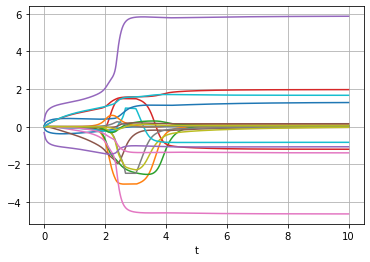

In [280]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [281]:
for i in range(coeff*N):  
    print(Y[-1][i])

0.008449657989251652
-0.01027514443777033
0.06772322560177912
-1.1990381483276682
5.865860723076412
-0.03586837444928778
-4.6345031844727425
-0.01274134449253663
-0.03472948320803789
-0.8317772037738504
1.2816971594221607
0.14964907533676614
0.052990283328525054
1.9678718163177629
-1.0673417386346673
0.15674295661666476
-1.3909959231942925
0.04267851486040279
0.04185777642969137
1.6671217469436874


In [282]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [283]:
def var_ansatz(theta,psi_0):
    psi = psi_0
    for i in range(coeff*N):
        psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

    return psi

In [284]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [285]:
psi = var_ansatz(start_point,psi_0)

In [286]:
psi_ground = eigenvec[:,0]


In [287]:
expt_value_u = np.zeros(len(time_domain))
energy = np.zeros(len(time_domain))

psi = var_ansatz(start_point,psi_0)
for tt in range(len(time_domain)):
    theta = []
    for i in range(coeff*N):
        theta.append(Y[tt][i])

    psi_var = var_ansatz(theta,psi_0)
    for i in range(L+1):
        psi_var = (Proj[i]+Proj_0[i])@psi_var
    norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))
    print(norm)

    expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
    energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)


0.9999954651602285
0.9999950645616742
0.9999875784082187
0.9999711014087453
0.9999453824210048
0.9999107528002344
0.9998677414316682
0.9998169323730659
0.9997589084865507
0.9996942284145489
0.9996234176159509
0.9995469656359096
0.9994653261955618
0.9993789185392151
0.9992881293028192
0.9991933145532078
0.9990948018330988
0.9989928921375199
0.9988878617917085
0.9987799642219558
0.9986694316206094
0.9985564765105212
0.9984412932154042
0.9983240592425153
0.9982049365834188
0.9980840729379047
0.9979616028653737
0.9978376488674062
0.9977123224047738
0.9975857248517557
0.9974579483904055
0.9973290768471743
0.9971991864742429
0.9970683466777756
0.9969366206953053
0.9968040662244183
0.9966707360048696
0.9965366783562932
0.9964019376735942
0.9962665548821674
0.9961305678550093
0.9959940117937657
0.9958569195757946
0.9957193220691676
0.9955812484176149
0.9954427262972586
0.9953037821470131
0.9951644413743975
0.9950247285385002
0.9948846675117445
0.9947442816220265
0.9946035937767465
0.9944626265

0.9881382203938021
0.988151472272372
0.9881641956120113
0.9881764130691933
0.9881881463069577
0.9881994160267855
0.9882102420020284
0.9882206431122675
0.9882306373781823
0.9882402419964952
0.9882494733746905
0.9882583471652736
0.9882668782993494
0.9882750810193801
0.9882829689110055
0.988290554933839
0.9882978514511763
0.9883048702585872
0.9883116226113645
0.9883181192508221
0.9883243704294499
0.9883303859349459
0.9883361751131284
0.9883417468897705
0.9883471097913892
0.9883522719650089
0.9883572411969501
0.9883620249306706
0.9883666302837033
0.9883710640637288
0.988375332783813
0.9883794426768735
0.9883833997093674
0.9883872095942818
0.988390877803449
0.9883944095791896
0.9883978099453724
0.9884010837178784
0.9884042355145122
0.988407269764403
0.9884101907169024
0.9884130024500223
0.9884157088784243
0.9884183137610045
0.9884208207080646
0.9884232331881312
0.9884255545344043
0.9884277879508867
0.988429936518188
0.9884320031990422
0.9884339908435307
0.9884359021940567
0.9884377398900498

0.9884512510990227
0.988451244967523
0.9884512389402993
0.9884512330157511
0.9884512271923006
0.9884512214683878
0.9884512158424765
0.9884512103130472
0.9884512048786038
0.9884511995376691
0.9884511942887836
0.9884511891305094
0.988451184061426
0.9884511790801348
0.9884511741852525
0.9884511693754172
0.9884511646492835
0.9884511600055234
0.9884511554428289
0.9884511509599108
0.9884511465554922
0.9884511422283179
0.9884511379771487
0.9884511338007622
0.9884511296979523
0.9884511256675299
0.9884511217083222
0.9884511178191715
0.9884511139989376
0.9884511102464951
0.9884511065607329
0.9884511029405598
0.9884510993848924
0.9884510958926701
0.9884510924628415
0.9884510890943721
0.9884510857862419
0.988451082537445
0.9884510793469872
0.9884510762138924
0.9884510731371967
0.988451070115949
0.9884510671492117
0.9884510642360603
0.9884510613755839
0.988451058566886
0.9884510558090802
0.9884510531012944
0.9884510504426676
0.988451047832352
0.9884510452695143
0.9884510427533286
0.9884510402829827

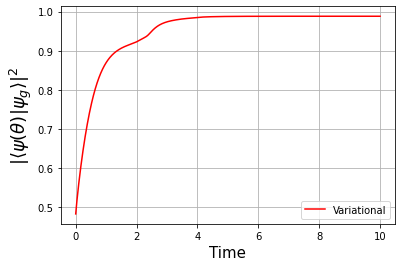

In [288]:
plt.plot(time_domain,expt_value_u, color = "red",label = "Variational")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.xlim(2.8,3)
#plt.ylim(0.99,1)

#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")

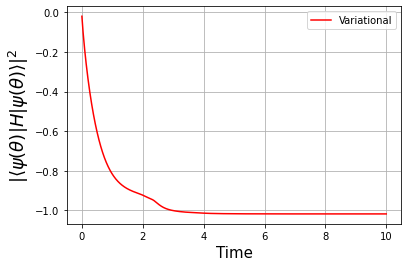

In [289]:
plt.plot(time_domain,energy, color = "red",label = "Variational")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
#plt.xlim(0,10)
#plt.ylim(-1.35,-1.25)

#plt.savefig("real_time_evolution\fermion_numbers_1layer.pdf")

In [290]:
print(expt_value_u[-1])

0.9879724745135823


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
